In [15]:
required_packages <- c("tidyverse", "caret", "data.table", "ggplot2", "readr", "dplyr")

for (pkg in required_packages) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
    library(pkg, character.only = TRUE)
  }
}

In [16]:
#Installing & preparing for coded project Moive Recommendation System Creation [Business Understanding Phase]
#The business problem thats solved here is to create a movie recommendation system that helps increase user retention
install.packages("randomForest")
library(randomForest)

Installing package into 'C:/Users/Mtize/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'randomForest' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'randomForest'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Mtize\AppData\Local\R\win-library\4.5\00LOCK\randomForest\libs\x64\randomForest.dll to C:\Users\Mtize\AppData\Local\R\win-library\4.5\randomForest\libs\x64\randomForest.dll: Permission denied"
Warning message:
"restored 'randomForest'"



The downloaded binary packages are in
	C:\Users\Mtize\AppData\Local\Temp\Rtmp8U33Jn\downloaded_packages


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




In [17]:
#Putting data set into notebook for coding [Data Understanding Phase]
if(!require(tidyverse)) install.packages("tidyverse", repos = "http://cran.us.r-project.org")
if(!require(caret)) install.packages("caret", repos = "http://cran.us.r-project.org")

library(tidyverse)
library(caret)

In [18]:
options(timeout = 120)
dl <- "ml-10M100K.zip"
if(!file.exists(dl))
  download.file("https://files.grouplens.org/datasets/movielens/ml-10m.zip", dl)
ratings_file <- "ml-10M100K/ratings.dat"
if(!file.exists(ratings_file))
  unzip(dl, ratings_file)
movies_file <- "ml-10M100K/movies.dat"
if(!file.exists(movies_file))
  unzip(dl, movies_file)
ratings <- as.data.frame(str_split(read_lines(ratings_file), fixed("::"), simplify = TRUE),
                         stringsAsFactors = FALSE)
colnames(ratings) <- c("userId", "movieId", "rating", "timestamp")
ratings <- ratings %>%
  mutate(userId = as.integer(userId),
         movieId = as.integer(movieId),
         rating = as.numeric(rating),
         timestamp = as.integer(timestamp))
movies <- as.data.frame(str_split(read_lines(movies_file), fixed("::"), simplify = TRUE),
                        stringsAsFactors = FALSE)
colnames(movies) <- c("movieId", "title", "genres")
movies <- movies %>%
  mutate(movieId = as.integer(movieId))
movielens <- left_join(ratings, movies, by = "movieId")

In [19]:
#Examining dataset
str(movielens)

'data.frame':	10000054 obs. of  6 variables:
 $ userId   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ movieId  : int  122 185 231 292 316 329 355 356 362 364 ...
 $ rating   : num  5 5 5 5 5 5 5 5 5 5 ...
 $ timestamp: int  838985046 838983525 838983392 838983421 838983392 838983392 838984474 838983653 838984885 838983707 ...
 $ title    : chr  "Boomerang (1992)" "Net, The (1995)" "Dumb & Dumber (1994)" "Outbreak (1995)" ...
 $ genres   : chr  "Comedy|Romance" "Action|Crime|Thriller" "Comedy" "Action|Drama|Sci-Fi|Thriller" ...


In [20]:
head(movielens)

,userId,movieId,rating,timestamp,title,genres
,<int>,<int>,<dbl>,<int>,<chr>,<chr>
1,1,122,5,838985046,Boomerang (1992),Comedy|Romance
2,1,185,5,838983525,"Net, The (1995)",Action|Crime|Thriller
3,1,231,5,838983392,Dumb & Dumber (1994),Comedy
4,1,292,5,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
5,1,316,5,838983392,Stargate (1994),Action|Adventure|Sci-Fi
6,1,329,5,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi


In [21]:
dim(movielens)

[1] 10000054        6

In [22]:
summary(movielens)

     userId         movieId          rating        timestamp        
 Min.   :    1   Min.   :    1   Min.   :0.500   Min.   :7.897e+08  
 1st Qu.:18123   1st Qu.:  648   1st Qu.:3.000   1st Qu.:9.468e+08  
 Median :35741   Median : 1834   Median :4.000   Median :1.035e+09  
 Mean   :35870   Mean   : 4120   Mean   :3.512   Mean   :1.033e+09  
 3rd Qu.:53608   3rd Qu.: 3624   3rd Qu.:4.000   3rd Qu.:1.127e+09  
 Max.   :71567   Max.   :65133   Max.   :5.000   Max.   :1.231e+09  
    title              genres         
 Length:10000054    Length:10000054   
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

In [23]:
#total number of unique movies 
unique_movies <- movielens %>%
distinct(movieId, title)

nrow(unique_movies)

[1] 10677

In [24]:
#ratings display 
rating_counts <- movielens %>%
  count(rating, sort = FALSE)

rating_counts

rating,n
<dbl>,<int>
0.5,94988
1.0,384180
1.5,118278
2.0,790306
2.5,370178
3.0,2356676
3.5,879764
4.0,2875850
4.5,585022


In [25]:
rating_levels <- seq(5, 0.5, by = -0.5)

# Count ratings from 5 stars to the lowest and i ensure all levels are included
rating_counts <- movielens %>%
  count(rating) %>%
  mutate(rating = factor(rating, levels = rating_levels)) %>%
  complete(rating, fill = list(n = 0)) %>%  # Fill in missing ratings with 0
  arrange(desc(as.numeric(as.character(rating))))  # Sort from 5.0 to 0.5

rating_counts

rating,n
<fct>,<int>
5,1544812
4.5,585022
4,2875850
3.5,879764
3,2356676
2.5,370178
2,790306
1.5,118278
1,384180


In [26]:
#Average movie rating across entire datset 
mean(movielens$rating)

[1] 3.512422

`summarise()` has grouped output by 'movieId'. You can override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


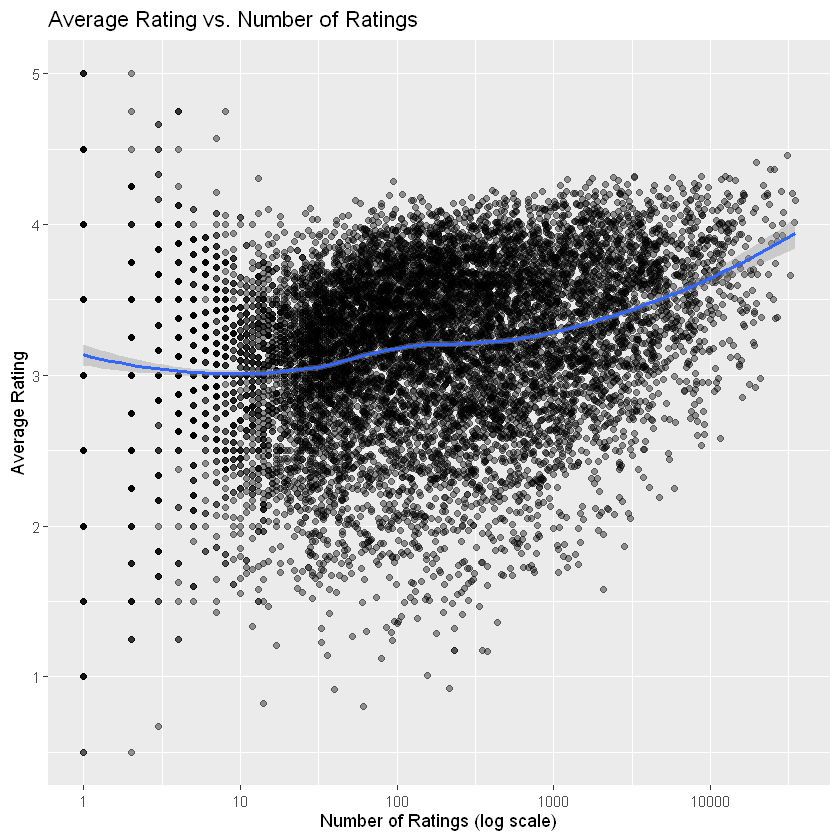

In [27]:
#[Data Explore/Prep phase]
#Exploring to see patterns around the highs, lows and average movie ratings reltaive to the number of ratings 
library(tidyverse)

movielens %>%
  group_by(movieId, title) %>%
  summarise(avg_rating = mean(rating), num_ratings = n()) %>%
  ggplot(aes(x = num_ratings, y = avg_rating)) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "loess") +
  scale_x_log10() +
  labs(title = "Average Rating vs. Number of Ratings",
       x = "Number of Ratings (log scale)",
       y = "Average Rating")

`summarise()` has grouped output by 'movieId'. You can override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


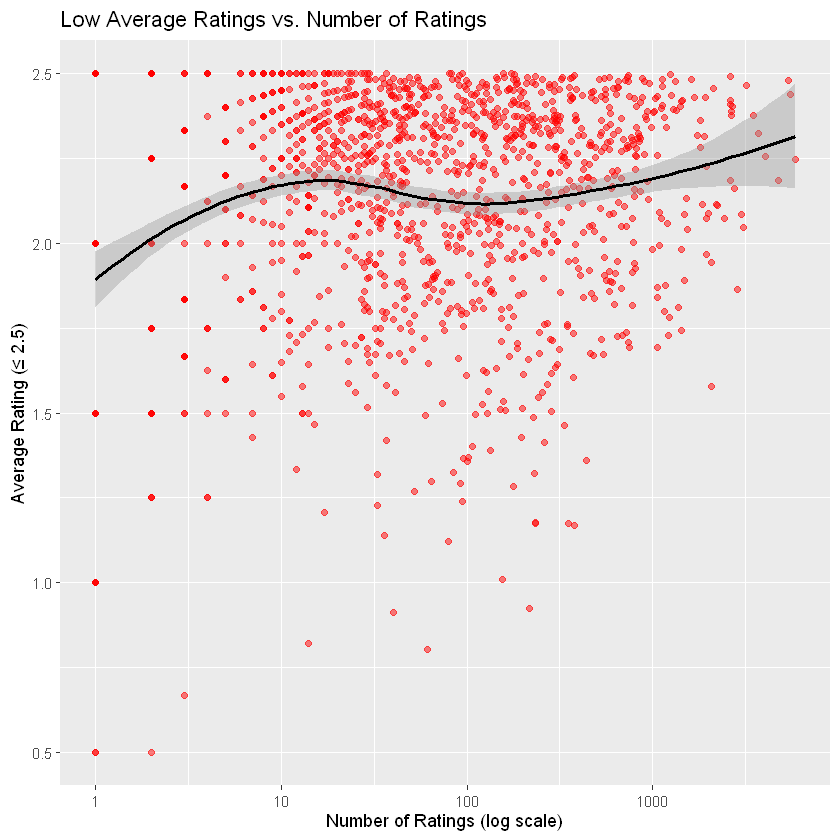

In [28]:
#Patterns that might be linked to low movie reviews
movielens %>%
  group_by(movieId, title) %>%
  summarise(avg_rating = mean(rating), num_ratings = n()) %>%
  filter(avg_rating <= 2.5) %>%  # Focus on lower-rated movies
  ggplot(aes(x = num_ratings, y = avg_rating)) +
  geom_point(alpha = 0.5, color = "red") +
  geom_smooth(method = "loess", color = "black") +
  scale_x_log10() +
  labs(title = "Low Average Ratings vs. Number of Ratings",
       x = "Number of Ratings (log scale)",
       y = "Average Rating (≤ 2.5)")


`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.0045154"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.48164"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  2.7466e-16"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 0.22764"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.0045154"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 0.48164"
Warning message in pre

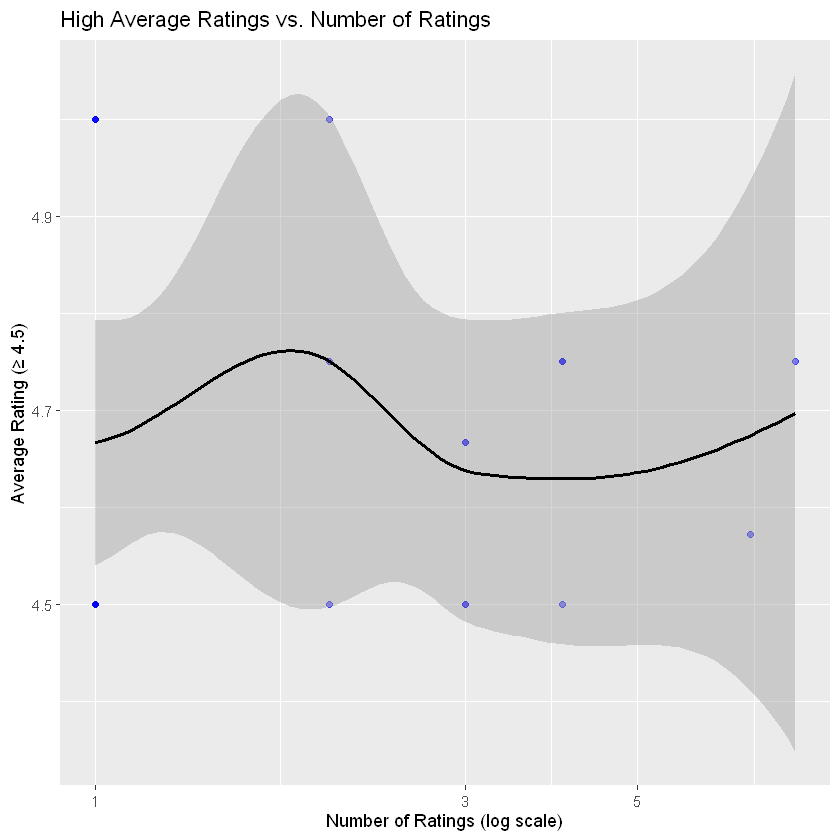

In [29]:
#patterns that might be linked to high movie ratings 
movielens %>%
  group_by(movieId, title) %>%
  summarise(avg_rating = mean(rating), num_ratings = n(), .groups = "drop") %>%
  filter(avg_rating >= 4.5) %>%  # Focus on high-rated movies
  ggplot(aes(x = num_ratings, y = avg_rating)) +
  geom_point(alpha = 0.5, color = "blue") +
  geom_smooth(method = "loess", color = "black") +
  scale_x_log10() +
  labs(title = "High Average Ratings vs. Number of Ratings",
       x = "Number of Ratings (log scale)",
       y = "Average Rating (≥ 4.5)")

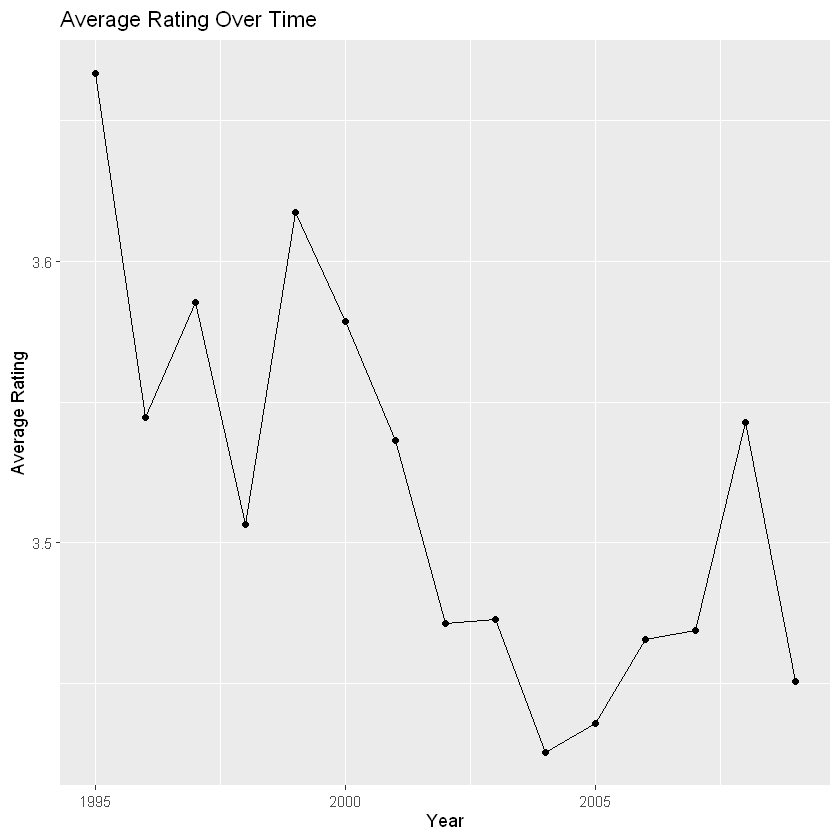

In [30]:
#Average moive rating over a span of time 
movielens %>%
  mutate(date = as.POSIXct(timestamp, origin = "1970-01-01")) %>%
  mutate(year = format(date, "%Y")) %>%
  group_by(year) %>%
  summarise(avg_rating = mean(rating)) %>%
  ggplot(aes(x = as.integer(year), y = avg_rating)) +
  geom_line() +
  geom_point() +
  labs(title = "Average Rating Over Time",
       x = "Year",
       y = "Average Rating")

In [31]:
library(dplyr)

In [32]:
#converting three variables in dataset called movielens into factors
movielens$userId <- as.factor(movielens$userId)
movielens$movieId <- as.factor(movielens$movieId)
movielens$genres <- as.factor(movielens$genres)

In [33]:
#identifying the top 10 most active users
top_users <- movielens %>%
  count(userId, sort = TRUE) %>%
  slice_head(n = 10) %>%
  pull(userId)

In [34]:
print(top_users)

 [1] 59269 67385 14463 68259 27468 3817  19635 63134 58357 27584
69878 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17 18 19 22 23 24 26 27 ... 71567


In [35]:
#identifying the top 10 most rated movies
top_movies <- movielens %>%
  count(movieId, sort = TRUE) %>%
  slice_head(n = 10) %>%
  pull(movieId)

In [36]:
print(top_movies)

 [1] 296 356 593 480 318 110 457 589 260 150
10677 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 65133


In [37]:
#average ratings for the top 10 users & the top 10 movies, grouped by user, movie, and genre.
agg <- movielens %>%
  filter(userId %in% top_users, movieId %in% top_movies) %>%
  group_by(userId, movieId, genres) %>%
  summarise(avg_rating = mean(rating), .groups = "drop")

In [38]:
print(agg)

# A tibble: 100 × 4
   userId movieId genres                           avg_rating
   <fct>  <fct>   <fct>                                 <dbl>
 1 3817   110     Action|Drama|War                        4  
 2 3817   150     Adventure|Drama                         3.5
 3 3817   260     Action|Adventure|Sci-Fi                 4  
 4 3817   296     Comedy|Crime|Drama                      4.5
 5 3817   318     Drama                                   4  
 6 3817   356     Comedy|Drama|Romance|War                3.5
 7 3817   457     Thriller                                3.5
 8 3817   480     Action|Adventure|Sci-Fi|Thriller        4  
 9 3817   589     Action|Sci-Fi                           4  
10 3817   593     Crime|Horror|Thriller                   4.5
# ℹ 90 more rows


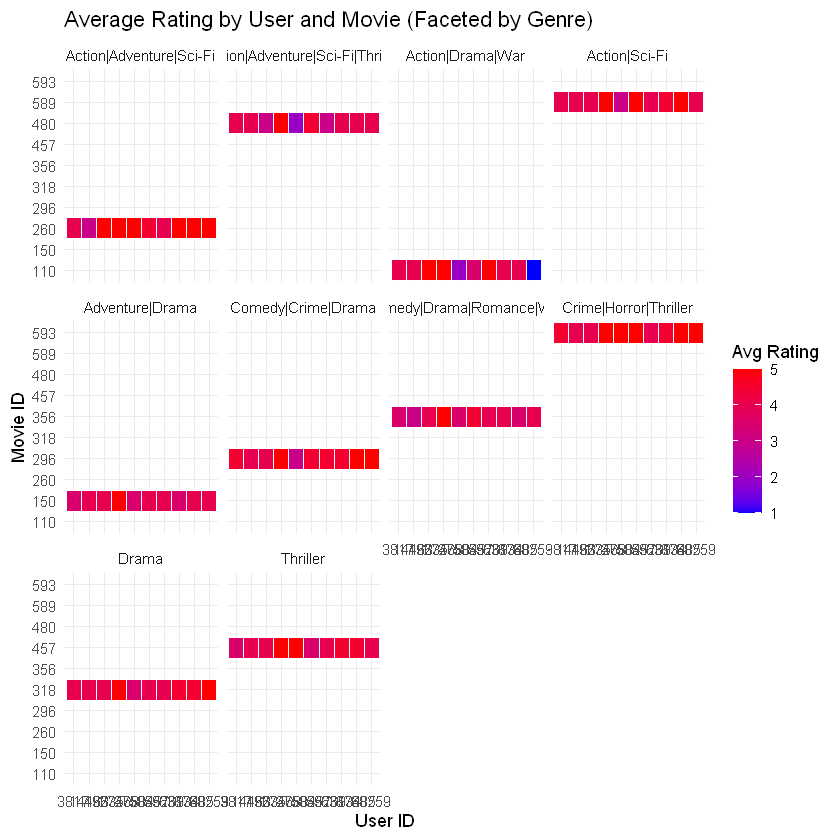

In [39]:
#heatmap of average ratings given by the top users to the top movies, faceted by genre
ggplot(agg, aes(x = as.factor(userId), y = as.factor(movieId), fill = avg_rating)) +
  geom_tile(color = "white") +
  facet_wrap(~genres) +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  labs(
    title = "Average Rating by User and Movie (Faceted by Genre)",
    x = "User ID",
    y = "Movie ID",
    fill = "Avg Rating"
  )

In [40]:
#Test/Train Split 80/20 ratio
set.seed(123)  # for reproducibility
train_index <- createDataPartition(movielens$rating, p = 0.8, list = FALSE)
train_data <- movielens[train_index, ]
test_data <- movielens[-train_index, ]

In [41]:
install.packages("ranger")

Installing package into 'C:/Users/Mtize/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'ranger' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'ranger'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Mtize\AppData\Local\R\win-library\4.5\00LOCK\ranger\libs\x64\ranger.dll to C:\Users\Mtize\AppData\Local\R\win-library\4.5\ranger\libs\x64\ranger.dll: Permission denied"
Warning message:
"restored 'ranger'"



The downloaded binary packages are in
	C:\Users\Mtize\AppData\Local\Temp\Rtmp8U33Jn\downloaded_packages


In [42]:
library(ranger)


Attaching package: 'ranger'


The following object is masked from 'package:randomForest':

    importance




In [43]:
#[Modeling Phase]
#training a Random Forest regression model
rf_model <- ranger(
  rating ~ userId + movieId + genres,
  data = train_data,
  num.trees = 10,
  importance = "impurity"
)

Growing trees.. Progress: 30%. Estimated remaining time: 1 minute, 35 seconds.
Growing trees.. Progress: 70%. Estimated remaining time: 34 seconds.


In [44]:
rf_model

Ranger result

Call:
 ranger(rating ~ userId + movieId + genres, data = train_data,      num.trees = 10, importance = "impurity") 

Type:                             Regression 
Number of trees:                  10 
Sample size:                      8000045 
Number of independent variables:  3 
Mtry:                             1 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       0.9299359 
R squared (OOB):                  0.1728272 

In [45]:
print(rf_model)

Ranger result

Call:
 ranger(rating ~ userId + movieId + genres, data = train_data,      num.trees = 10, importance = "impurity") 

Type:                             Regression 
Number of trees:                  10 
Sample size:                      8000045 
Number of independent variables:  3 
Mtry:                             1 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       0.9299359 
R squared (OOB):                  0.1728272 


In [46]:
str(rf_model)

List of 17
 $ predictions              : num [1:8000045] 5 4.12 4.55 4.6 5 ...
 $ num.trees                : num 10
 $ num.independent.variables: num 3
 $ mtry                     : num 1
 $ min.node.size            : num 5
 $ variable.importance      : Named num [1:3] 414139 1049519 760461
  ..- attr(*, "names")= chr [1:3] "userId" "movieId" "genres"
 $ prediction.error         : num 0.93
 $ forest                   :List of 8
  ..$ num.trees                 : num 10
  ..$ child.nodeIDs             :List of 10
  ..$ split.varIDs              :List of 10
  ..$ split.values              :List of 10
  ..$ is.ordered                : logi [1:3] TRUE TRUE TRUE
  ..$ independent.variable.names: chr [1:3] "userId" "movieId" "genres"
  ..$ treetype                  : chr "Regression"
  ..$ covariate.levels          :List of 3
 $ splitrule                : chr "variance"
 $ treetype                 : chr "Regression"
 $ r.squared                : num 0.173
 $ call                     : languag

In [47]:
#predictions from Random Forest Model Created ; predicted movie ratings on the test dataset
predictions <- predict(rf_model, data = test_data)$prediction

In [48]:
print(predictions)

    [1] 3.920602 4.355191 4.098648 2.504487 3.949079 4.014167 3.546190 3.559002
    [9] 3.988333 4.195833 4.556981 3.730750 3.462436 3.617704 3.433109 3.742437
   [17] 3.336205 2.904482 4.197119 4.023355 3.397986 3.413365 4.008162 3.469337
   [25] 3.232181 3.554295 3.668234 3.273772 4.714706 4.260393 4.112393 4.162500
   [33] 3.700833 3.628174 3.695331 4.289731 3.788761 4.259914 3.789487 3.443333
   [41] 3.704404 3.460644 3.667955 3.888979 3.511970 3.030000 3.303333 2.962052
   [49] 2.330000 4.547931 3.856892 4.367883 4.586721 3.468421 4.235095 4.037304
   [57] 4.787271 3.989009 4.455303 3.811401 3.520833 3.904241 4.008194 4.259762
   [65] 3.602500 2.984583 4.142500 2.954823 3.245833 3.654243 3.781667 3.781310
   [73] 4.083734 3.000618 4.226889 4.290976 3.230000 3.610773 3.243152 3.325638
   [81] 3.233049 4.084595 3.564643 3.756786 3.611134 3.284354 3.236754 3.305704
   [89] 3.601567 3.809519 3.951688 3.284219 3.953488 3.421111 3.856892 3.303333
   [97] 2.353327 3.477976 4.189405 3.668

In [49]:
#[Model Evaluation & Deployment Phase] 
rmse <- sqrt(mean((predictions - test_data$rating)^2))
cat("RMSE on test set:", rmse, "\n")

RMSE on test set: 0.9535407 


In [50]:
print(rmse)

[1] 0.9535407


In [51]:
# Final hold-out test set will be 10% of MovieLens data
set.seed(1, sample.kind="Rounding") # if using R 3.6 or later
# set.seed(1) # if using R 3.5 or earlier
test_index <- createDataPartition(y = movielens$rating, times = 1, p = 0.1, list = FALSE)
edx <- movielens[-test_index,]
temp <- movielens[test_index,]

# Make sure userId and movieId in final hold-out test set are also in edx set
final_holdout_test <- temp %>% 
  semi_join(edx, by = "movieId") %>%
  semi_join(edx, by = "userId")

# Add rows removed from final hold-out test set back into edx set
removed <- anti_join(temp, final_holdout_test)
edx <- rbind(edx, removed)

rm(dl, ratings, movies, test_index, temp, movielens, removed)

Warning message in set.seed(1, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"
Joining with `by = join_by(userId, movieId, rating, timestamp, title, genres)`


In [58]:
predicted_ratings <- predict(rf_model, data = final_holdout_test)$predictions

In [59]:
RMSE <- function(true_ratings, predicted_ratings) {
  sqrt(mean((true_ratings - predicted_ratings)^2))
}

In [60]:
final_rmse <- RMSE(final_holdout_test$rating, predicted_ratings)
cat("Final RMSE of random forest on holdout test set:", final_rmse, "\n")

Final RMSE of random forest on holdout test set: 0.9221101 


In [65]:
#RMSE is to High So will make adjustments to get a better RMSE Score

In [66]:
# ensemble averaging approach to combine predictions of my rf_model and a baseline model with 
#regularized movie plus user effects
mu <- mean(edx$rating)

In [91]:
lambda <- 0.25

In [92]:
b_i <- edx %>%
  group_by(movieId) %>%
  summarize(b_i = sum(rating - mu) / (n() + lambda))

In [93]:
b_u <- edx %>%
  left_join(b_i, by = "movieId") %>%
  group_by(userId) %>%
  summarize(b_u = sum(rating - mu - b_i) / (n() + lambda))

In [94]:
baseline_preds <- final_holdout_test %>%
  left_join(b_i, by = "movieId") %>%
  left_join(b_u, by = "userId") %>%
  mutate(pred = mu + b_i + b_u) %>%
  pull(pred)

In [95]:
rf_preds <- predict(rf_model, data = final_holdout_test)$predictions

In [96]:
ensemble_preds <- (baseline_preds + rf_preds) / 2

In [97]:
RMSE <- function(true, pred) sqrt(mean((true - pred)^2))

In [98]:
#RMSE improved but is still not ideal
final_rmse <- RMSE(final_holdout_test$rating, ensemble_preds)
cat("Final ensemble RMSE:", final_rmse, "\n")

Final ensemble RMSE: 0.8700646 


In [99]:
#To improve even better the RMSE score i give the combined model different weighted averages so the weight of the predictions lean
#more toward the better model
w <- 0.7  # weight for baseline model
ensemble_preds <- w * baseline_preds + (1 - w) * rf_preds
final_rmse <- RMSE(final_holdout_test$rating, ensemble_preds)
cat("Weighted ensemble RMSE:", final_rmse, "\n")

Weighted ensemble RMSE: 0.8622617 
